# Diagnose depth sensitivity in PIG setup

Depth sensitivities look like noise. Try to find out why.

Consider 

### $J = \langle \eta \rangle^{\text{1mo}}$

at 4 ''mooring'' locations off shore of iceshelf extent. Show:

- sensitivity to
    - 3D initial temperature & salinity
    - 2D depth & bottom drag
    - 2D $\eta$ (should be 1:1)
    
- forward state diagnostics
    - bottom & surface pressure
    - barotropic & meridional streamfunctions
    - vertical velocity

And consider how the forward state diagnostics (particularly $w$) varies after cranking up cg2d accuracy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from xmitgcm import open_mdsdataset
from MITgcmutils import rdmds

In [2]:
reg_cg2d_dir = '/workspace/results/pig/depth-sens-diag/reg-cg2d'
high_accuracy_dir = '/workspace/results/pig/depth-sens-diag/target-res-10m15/'
grid_dir = ('%s/extra-grid' % reg_cg2d_dir)

fwd = open_mdsdataset(data_dir=('%s/diags' % reg_cg2d_dir),
                      grid_dir=grid_dir)
ctrl= open_mdsdataset(data_dir=('%s' % reg_cg2d_dir),
                      grid_dir=grid_dir,
                      ignore_unknown_vars=True)
dump= open_mdsdataset(data_dir=('%s/adj-diags' % reg_cg2d_dir),
                      grid_dir=grid_dir,
                      ignore_unknown_vars=True)

fwd_high = open_mdsdataset(data_dir=('%s/diags' % high_accuracy_dir),
                      grid_dir=grid_dir)
ctrl_high= open_mdsdataset(data_dir=('%s' % high_accuracy_dir),
                           grid_dir=grid_dir,
                           ignore_unknown_vars=True)
dump_high= open_mdsdataset(data_dir=('%s/adj-diags' % high_accuracy_dir),
                      grid_dir=grid_dir,
                      ignore_unknown_vars=True)
print(ctrl)

/workspace/xmitgcm/xmitgcm/mds_store.py:812: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/depth-sens-diag/reg-cg2d. Using default version.
  "in %s. Using default version." % data_dir)
/workspace/xmitgcm/xmitgcm/mds_store.py:812: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/depth-sens-diag/target-res-10m15/. Using default version.
  "in %s. Using default version." % data_dir)


<xarray.Dataset>
Dimensions:          (XC: 25, XG: 25, YC: 30, YG: 30, Z: 50, Zl: 50, Zp1: 51, Zu: 50, time: 1)
Coordinates:
    iter             (time) int64 0
  * time             (time) int64 0
  * XC               (XC) >f4 -102.3125 -102.1875 ... -99.4375 -99.3125
  * YC               (YC) >f4 -75.42998 -75.3985 ... -74.52348 -74.49012
  * XG               (XG) >f4 -102.375 -102.25 -102.125 ... -99.5 -99.375
  * YG               (YG) >f4 -75.4457 -75.41425 ... -74.54014 -74.50682
  * Z                (Z) >f4 -10.0 -30.0 -50.0 -70.0 ... -950.0 -970.0 -990.0
  * Zp1              (Zp1) >f4 0.0 -20.0 -40.0 -60.0 ... -960.0 -980.0 -1000.0
  * Zu               (Zu) >f4 -20.0 -40.0 -60.0 -80.0 ... -960.0 -980.0 -1000.0
  * Zl               (Zl) >f4 0.0 -20.0 -40.0 -60.0 ... -940.0 -960.0 -980.0
    rA               (YC, XC) >f4 dask.array<shape=(30, 25), chunksize=(30, 25)>
    dxG              (YG, XC) >f4 dask.array<shape=(30, 25), chunksize=(30, 25)>
    dyG              (YC, XG) >f4 d

In [3]:
def diag_plot(x,y,fld1,fld2,title1=None,title2=None,depth=None):
    plt.figure(figsize=(15,6))

    
    plt.subplot(1,2,1)
    nice_plot(x,y,fld1,title1,depth)
    
    plt.subplot(1,2,2)
    nice_plot(x,y,fld2,title2,depth)
    
    plt.show()
    
def nice_plot(x,y,fld,titleStr,depth): 
    
    cmax = np.max(np.abs(fld.values))
    
    ncolors = None 
    if fld.name == 'SALT':    
        cmin=33
        cmap=plt.get_cmap(name='YlGnBu',lut=ncolors)
    else:
        cmin=-cmax
        cmap=plt.get_cmap(name='BrBG_r',lut=ncolors)
    
    if 'time' in fld.dims:
        fld=fld.isel(time=0)
        
    plt.pcolormesh(x,y,fld,
                   vmin=cmin, vmax=cmax,
                   cmap=cmap)
                   #shading='gouraud')
    plt.colorbar()
    
    # If depth given, overlay bathymetry contours
    if depth is not None:
        plt.contour(depth.XC,depth.YC,depth.Depth,colors='0.5')
    
    if titleStr is not None:
        plt.title(titleStr)
    

In [4]:
xc = fwd.XC
yc = fwd.YC
xg = fwd.XG
yg = fwd.YG

### First, some basic forward state diagnostics as 5 day averages over 1 simulation period after 3yr spinup

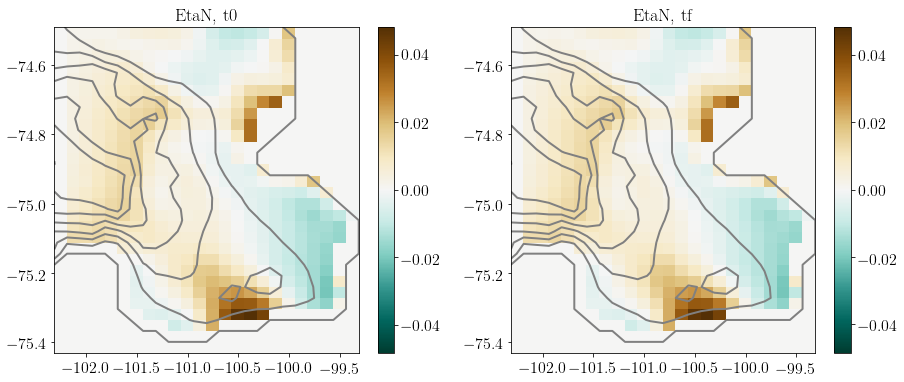

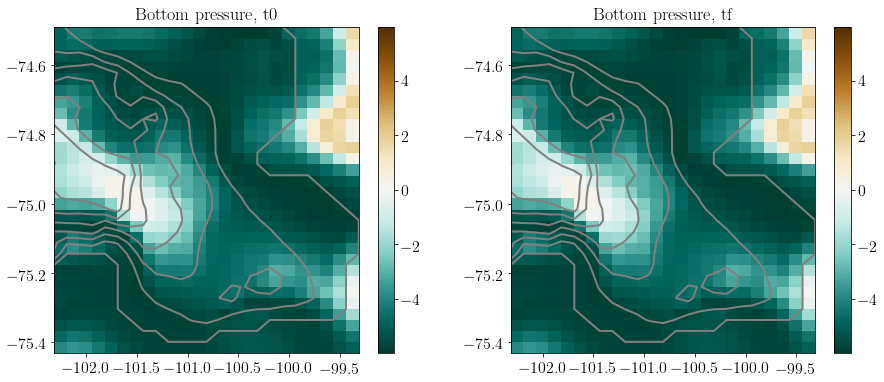

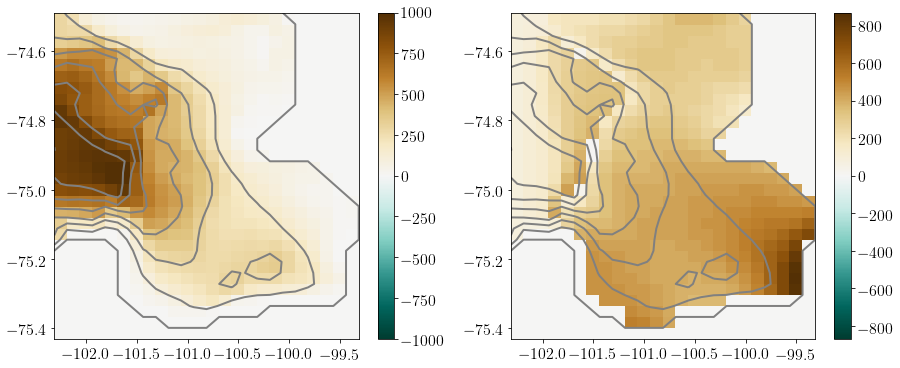

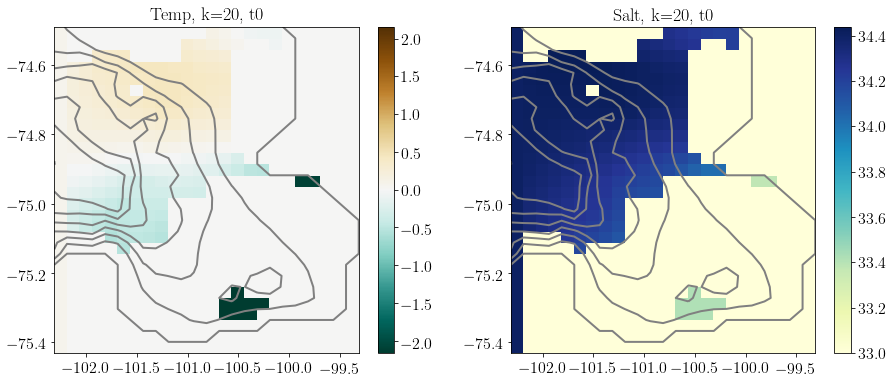

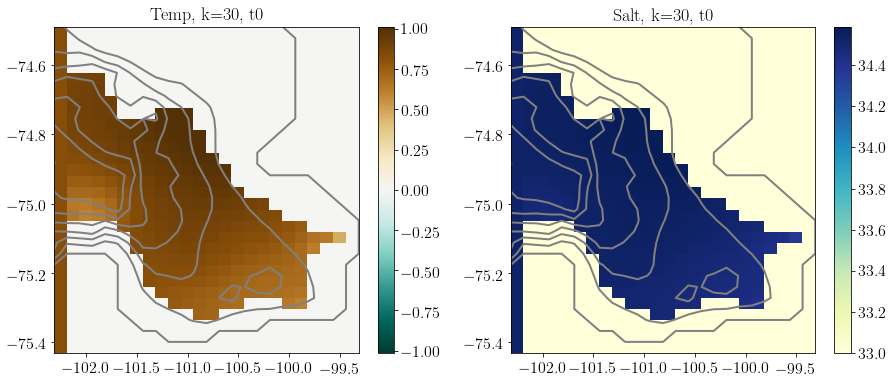

In [5]:
diag_plot(xc,yc,fwd.ETAN.isel(time=0),fwd.ETAN.isel(time=-1),title1='EtaN, t0',title2='EtaN, tf',depth=fwd.Depth)
diag_plot(xc,yc,fwd.PHIBOT.isel(time=0),fwd.PHIBOT.isel(time=-1),
          title1='Bottom pressure, t0',title2='Bottom pressure, tf',depth=fwd.Depth)
diag_plot(xc,yc,fwd.Depth,fwd.MXLDEPTH,depth=fwd.Depth)
zlev = 20
diag_plot(xc,yc,fwd.THETA.isel(Z=zlev,time=0),fwd.SALT.isel(Z=zlev,time=0),
         title1=('Temp, k=%d, t0' % zlev),title2=('Salt, k=%d, t0' % zlev),depth=fwd.Depth)
zlev = 30
diag_plot(xc,yc,fwd.THETA.isel(Z=zlev,time=0),fwd.SALT.isel(Z=zlev,time=0),
         title1=('Temp, k=%d, t0' % zlev),title2=('Salt, k=%d, t0' % zlev),depth=fwd.Depth)

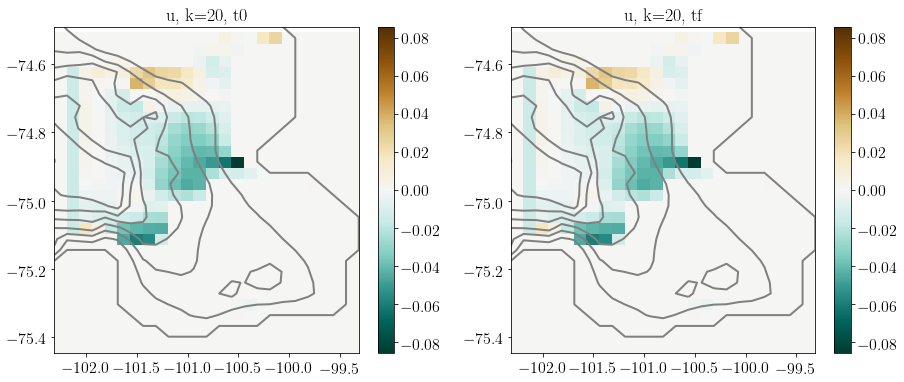

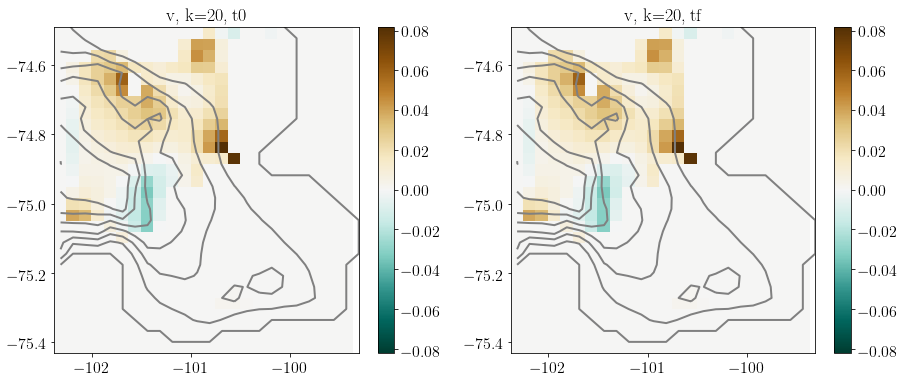

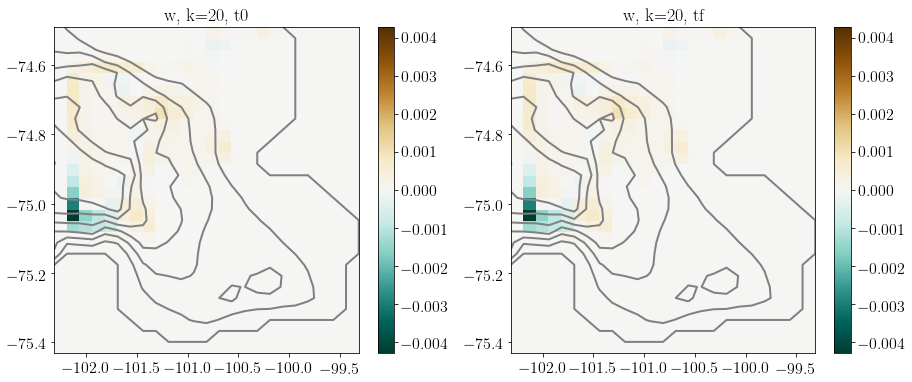

In [6]:
zlev = 20
diag_plot(xc,yg,fwd.UVELMASS.isel(Z=zlev,time=0),fwd.UVELMASS.isel(Z=zlev,time=-1),
         title1=('u, k=%d, t0' % zlev),title2=('u, k=%d, tf' % zlev),depth=fwd.Depth)
diag_plot(xg,yc,fwd.VVELMASS.isel(Z=zlev,time=0),fwd.VVELMASS.isel(Z=zlev,time=-1),
         title1=('v, k=%d, t0' % zlev),title2=('v, k=%d, tf' % zlev),depth=fwd.Depth)
diag_plot(xc,yc,fwd.WVELMASS.isel(Zl=zlev,time=0),fwd.WVELMASS.isel(Zl=zlev,time=-1),
         title1=('w, k=%d, t0' % zlev),title2=('w, k=%d, tf' % zlev),depth=fwd.Depth)



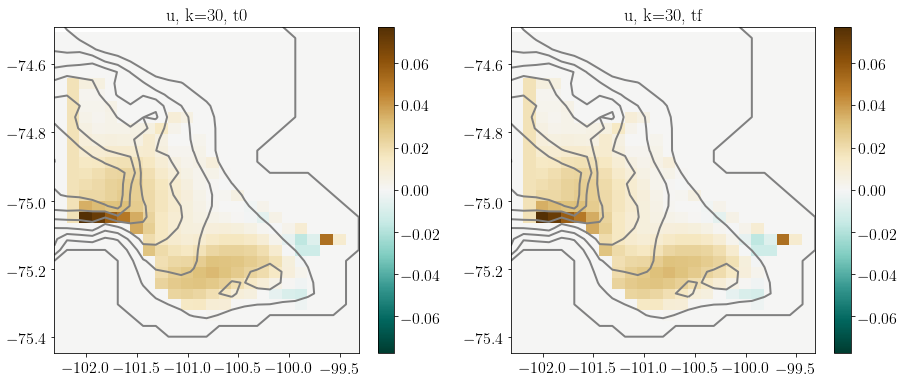

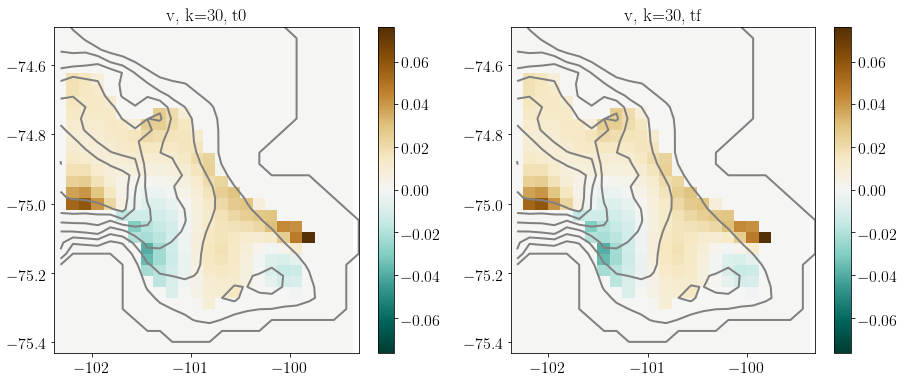

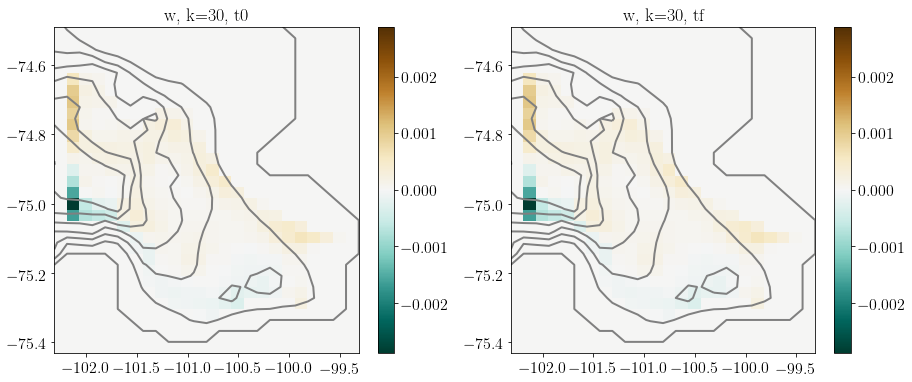

In [7]:
zlev = 30
diag_plot(xc,yg,fwd.UVELMASS.isel(Z=zlev,time=0),fwd.UVELMASS.isel(Z=zlev,time=-1),
         title1=('u, k=%d, t0' % zlev),title2=('u, k=%d, tf' % zlev),depth=fwd.Depth)
diag_plot(xg,yc,fwd.VVELMASS.isel(Z=zlev,time=0),fwd.VVELMASS.isel(Z=zlev,time=-1),
         title1=('v, k=%d, t0' % zlev),title2=('v, k=%d, tf' % zlev),depth=fwd.Depth)
diag_plot(xc,yc,fwd.WVELMASS.isel(Zl=zlev,time=0),fwd.WVELMASS.isel(Zl=zlev,time=-1),
         title1=('w, k=%d, t0' % zlev),title2=('w, k=%d, tf' % zlev),depth=fwd.Depth)

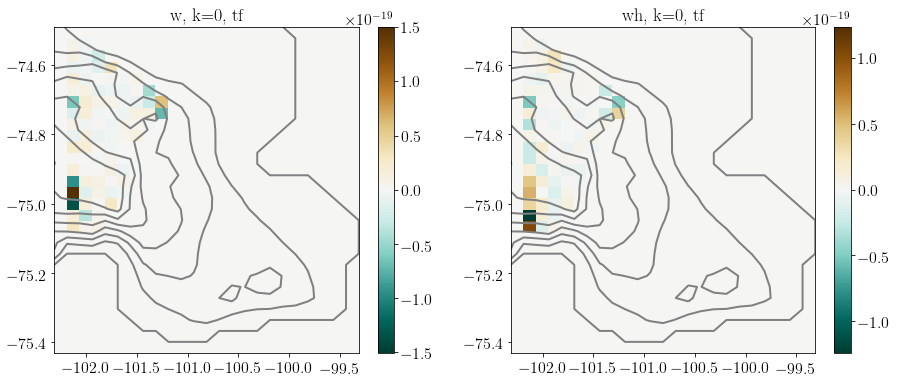

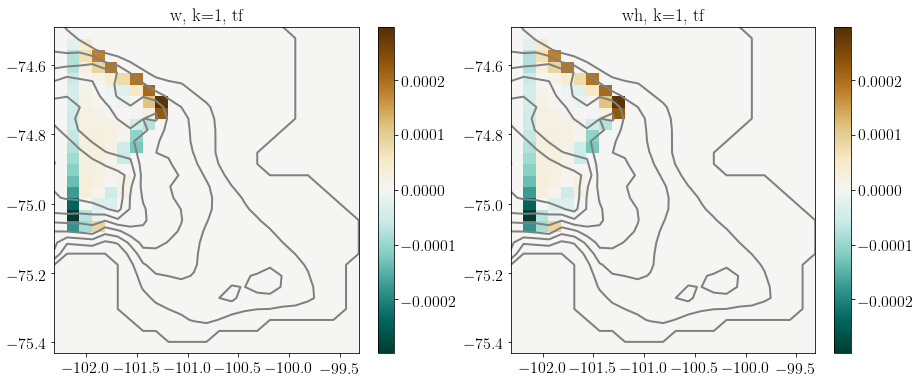

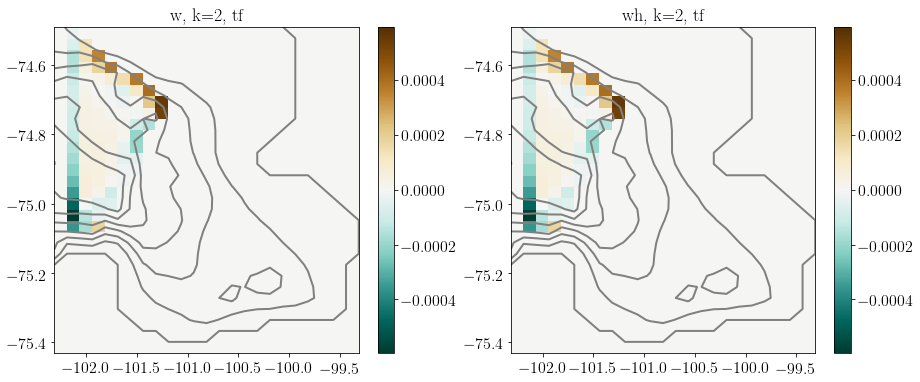

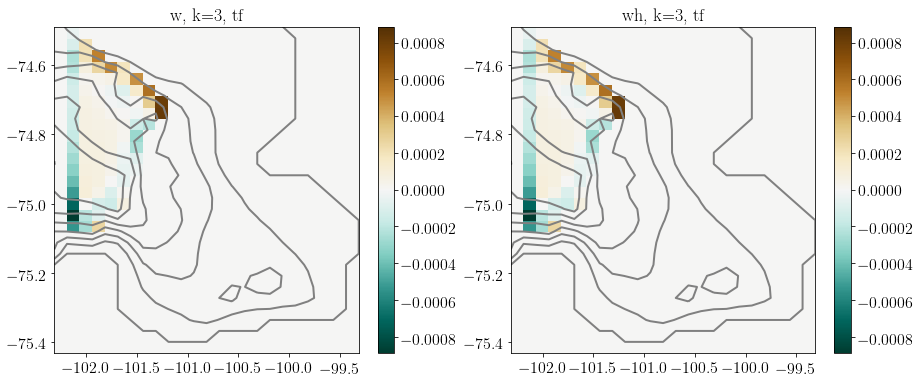

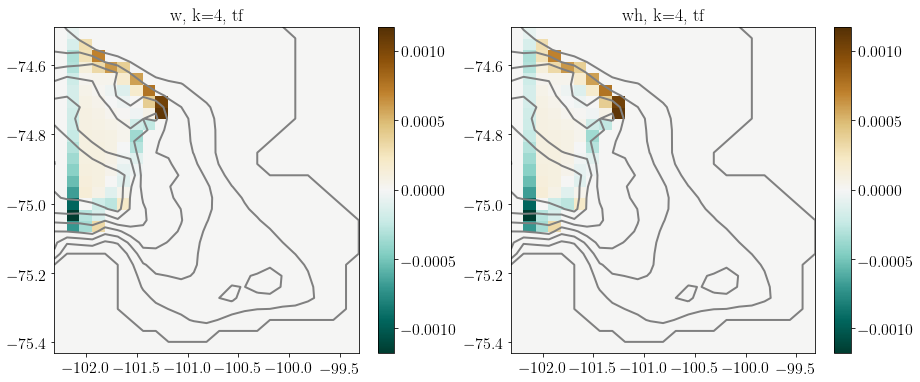

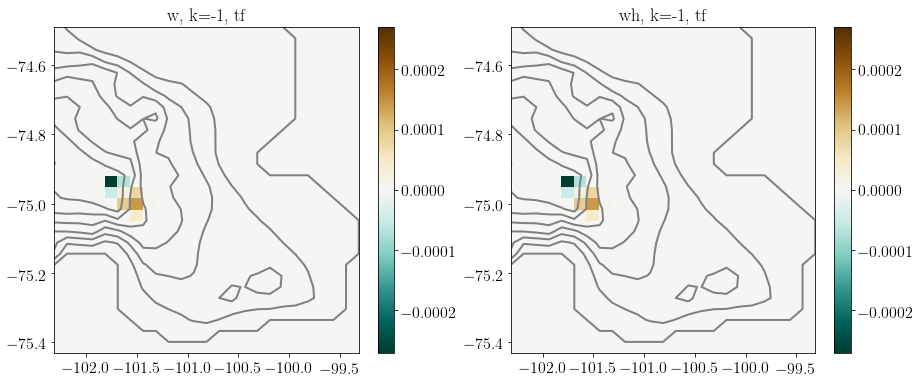

In [8]:
zlev=0
diag_plot(xc,yc,fwd.WVELMASS.isel(Zl=zlev,time=-1),fwd_high.WVELMASS.isel(Zl=zlev,time=-1),
         title1=('w, k=%d, tf' % zlev),title2=('wh, k=%d, tf' % zlev),depth=fwd.Depth)
zlev=1
diag_plot(xc,yc,fwd.WVELMASS.isel(Zl=zlev,time=-1),fwd_high.WVELMASS.isel(Zl=zlev,time=-1),
         title1=('w, k=%d, tf' % zlev),title2=('wh, k=%d, tf' % zlev),depth=fwd.Depth)
zlev=2
diag_plot(xc,yc,fwd.WVELMASS.isel(Zl=zlev,time=-1),fwd_high.WVELMASS.isel(Zl=zlev,time=-1),
         title1=('w, k=%d, tf' % zlev),title2=('wh, k=%d, tf' % zlev),depth=fwd.Depth)
zlev=3
diag_plot(xc,yc,fwd.WVELMASS.isel(Zl=zlev,time=-1),fwd_high.WVELMASS.isel(Zl=zlev,time=-1),
         title1=('w, k=%d, tf' % zlev),title2=('wh, k=%d, tf' % zlev),depth=fwd.Depth)
zlev=4
diag_plot(xc,yc,fwd.WVELMASS.isel(Zl=zlev,time=-1),fwd_high.WVELMASS.isel(Zl=zlev,time=-1),
         title1=('w, k=%d, tf' % zlev),title2=('wh, k=%d, tf' % zlev),depth=fwd.Depth)
zlev=-1
diag_plot(xc,yc,fwd.WVELMASS.isel(Zl=zlev,time=-1),fwd_high.WVELMASS.isel(Zl=zlev,time=-1),
         title1=('w, k=%d, tf' % zlev),title2=('wh, k=%d, tf' % zlev),depth=fwd.Depth)

In [9]:
def calc_vertical_avg(fld,msk):
    """Compute vertical average, ignoring continental or iceshelf points """
    
    # Make mask of nans, assume input msk is 3D of same size as fld 3 spatial dims
    nanmsk = np.where(msk==1,1,np.NAN)
    v_avg = fld.copy()
    v_avg.values = v_avg.values*msk.values
    
    if 'Z' in fld.dims:
        vdim = 'Z'
        
    elif 'Zl' in fld.dims:
        vdim = 'Zl'
        
    else:
        print('Vertical coordinate not prepared for fld')
        print(fld)
        
    # Once vertical coordinate is found, compute avg along dimension
    v_avg = v_avg.sum(dim=vdim,skipna=True)
    
    return v_avg

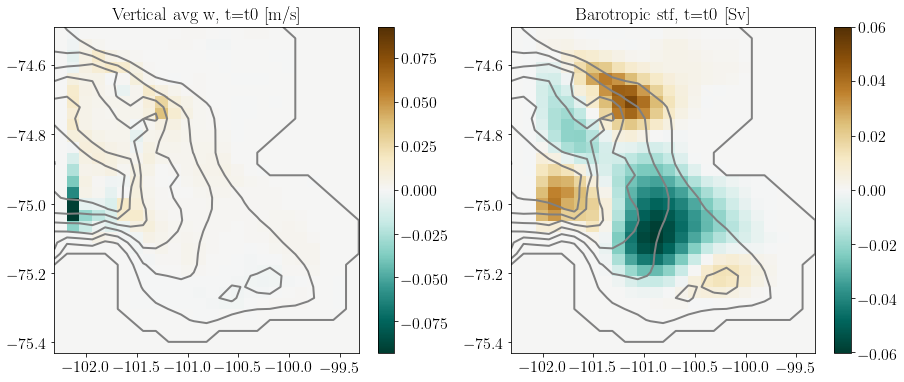

In [10]:
w_avg = calc_vertical_avg(fwd.WVELMASS,fwd.maskCtrlC)
baro_stf = calc_vertical_avg(fwd.PsiVEL,fwd.maskCtrlC) * pow(10,-6) # to Sv
diag_plot(xc,yc,w_avg.isel(time=0),baro_stf.isel(time=0),
          title1='Vertical avg w, t=t0 [m/s]',title2='Barotropic stf, t=t0 [Sv]',
          depth=fwd.Depth)

### Sensitivities 

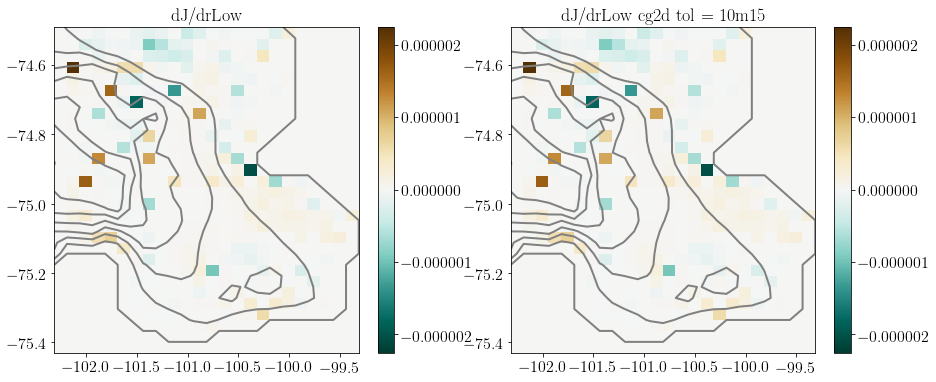

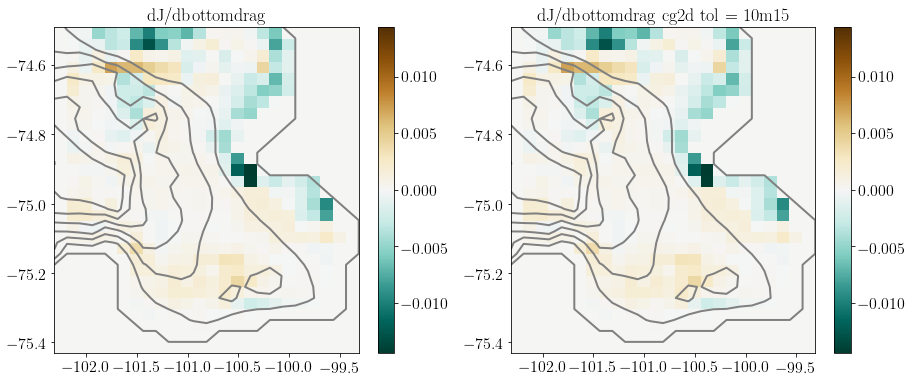

In [11]:
diag_plot(xc,yc,ctrl.adxx_depth,ctrl_high.adxx_depth,depth=ctrl.Depth,
         title1='dJ/drLow', title2='dJ/drLow cg2d tol = 10m15')
diag_plot(xc,yc,ctrl.adxx_bottomdrag,ctrl_high.adxx_bottomdrag,depth=ctrl.Depth,
         title1='dJ/dbottomdrag', title2='dJ/dbottomdrag cg2d tol = 10m15')

It does not seem like reducing the CG2D tolerance makes the picture for depth sensitivities any clearer...

## Now try a different objective function

### $\langle J \rangle^{\text{1mo}}$ at end of 3 months

In [14]:
three_month_dir = '/workspace/results/pig/depth-sens-diag/target-res-10m15-3mo'
fwd_3mo  = open_mdsdataset(data_dir=('%s/diags' % three_month_dir),
                      grid_dir=grid_dir)
ctrl_3mo = open_mdsdataset(data_dir=('%s' % three_month_dir),
                      grid_dir=grid_dir,
                      ignore_unknown_vars=True)
dump_3mo = open_mdsdataset(data_dir=('%s/adj-diags' % three_month_dir),
                      grid_dir=grid_dir,
                      ignore_unknown_vars=True)

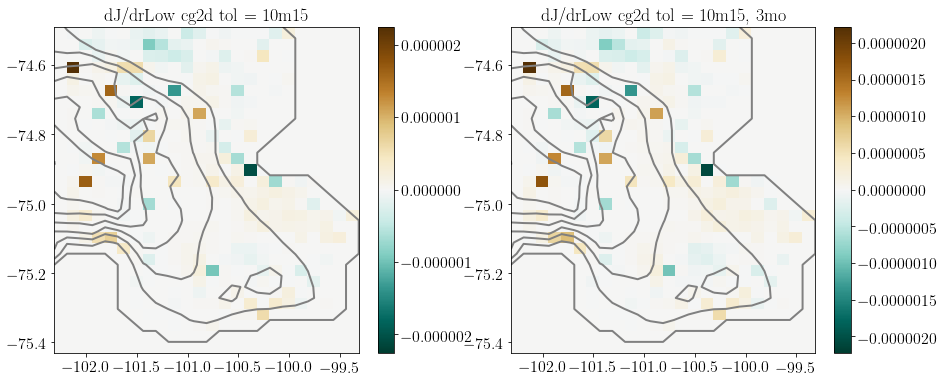

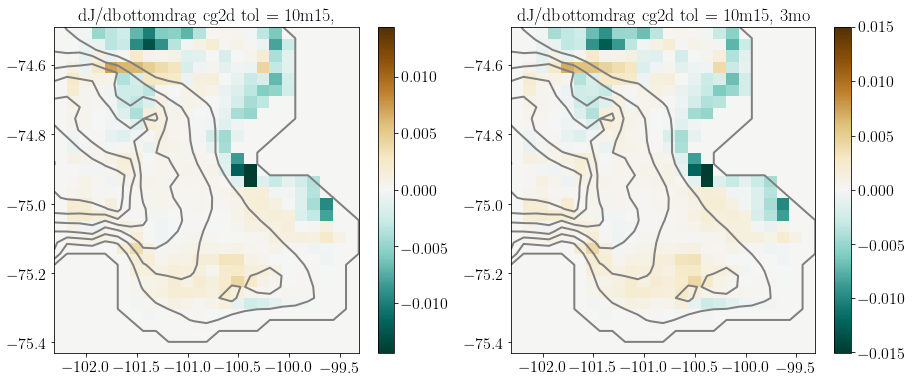

In [15]:
diag_plot(xc,yc,ctrl_high.adxx_depth,ctrl_3mo.adxx_depth,depth=ctrl.Depth,
         title1='dJ/drLow cg2d tol = 10m15', title2='dJ/drLow cg2d tol = 10m15, 3mo')
diag_plot(xc,yc,ctrl_high.adxx_bottomdrag,ctrl_3mo.adxx_bottomdrag,depth=ctrl.Depth,
         title1='dJ/dbottomdrag cg2d tol = 10m15,', title2='dJ/dbottomdrag cg2d tol = 10m15, 3mo')

In [ ]:
print(dump_3mo.time)